# Quantum implementation of non-unitary operations with biorthogonal representations

Authors of paper: Efstratios Koukoutsis, Panagiotis Papagiannis, Kyriakos Hizanidis, Abhay K. Ram, George Vahala, Oscar Amaro, Lucas I Inigo Gamiz, Dimosthenis Vallis

Link to pre-print: https://arxiv.org/abs/2410.22505

Notebook by: Óscar Amaro (2025)

**Abstract:** In this notebook we show an example application of the Dilation approach as introduced in the paper, compared with Linear Combination of Unitaries (LCU).

In [1]:
import numpy as np
from numpy import pi, exp, log, sqrt
import matplotlib.pyplot as plt
import json
from functools import reduce

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import random_unitary, Operator
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import MCXGate
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit, QuantumRegister

## Dilation method

Assume we want to apply the non-hermitian operator $\hat{V} \equiv \left[\begin{matrix} 1 & -2 \\ 0 & -1\end{matrix} \right]$ in a quantum computer to a quantum state.

For the Dilation Approach, we decompose $\hat{V} = \sigma_z -(\sigma_x+i\sigma_y)$.

We parametrize the initial wavefunction state $\psi = (a_0, a_1)^T, a_i \in \mathbb{C}^2$ as $\psi = (a_0, e^{i \gamma} \sqrt{1-a_0^2})^T, a_0, \gamma \in \mathbb{R}$.

The first step of the algorithm produces a state $\psi_1 = U_{prep} \psi_0 = (c_0, c_1)^T / c$, with $c_0=a_0-a_1$, $c_1=\sqrt{2} a_1$, and $c=\sqrt{|c_0|^2+|c_1|^2}$.

The code below creates the quantum circuit as shown in figure 2 of the paper, and provides the success probability sampled with ```qiskit_aer```.

In [2]:
def method_dilation(a0, gamma, nshots):

    # define non-hermitian operation as in equation 49
    Vop = np.array([[1,-2],[0,-1]]) 
    # initial state    
    a1 = np.sqrt(1-a0**2) * exp(1j * gamma)
    psi0 = np.array([ a0, a1 ])
    #print("psi0", psi0 )
    
    # bi-orthogonal 
    c0 = a0-a1
    c1 = sqrt(2) * a1
    psi_c = np.array([c0, c1])
    psi_c /= np.sqrt( np.sum(np.abs(psi_c)**2) )
    #print("psi_c", psi_c )
    
    
    # start quantum circuit
    qc = QuantumCircuit(2, 1)  # 1 ancillary qubit + 1 working qubit, 1 classical bit
    
    # Step 1: Apply Uprep to |psi>
    # through initialization of qubit 0
    qc.initialize(psi_c, 0)
    
    # Step 2: apply sigma_z to qubit 0
    qc.z(0)
    
    # Step 3: apply controlled-Hadamard
    qc.ch(0,1)
    
    # Step 4: apply Hadamard to qubit 0
    qc.h(0)
    
    # Measurement of ancillary qubit
    qc.measure(0, 0)
    
    # Step 3: Simulate the circuit
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=nshots).result()
    counts = result.get_counts()
    
    # Post-process results
    psuccess_aer = counts.get('0', 0) / nshots  # Probability of measuring '0'
    
    # expected probability
    psuccess_theory = ( np.abs(a0-2*a1)**2 + np.abs(a1)**2 )/( 2*( np.abs(a0-a1)**2 + 2*np.abs(a1)**2 ) ) 

    return psuccess_aer, psuccess_theory, qc

FIG. 2. Quantum circuit implementation of non-unitary operator V in Eq.(49), following the procedure of Eq.(54). The measurement outcome in the first register is conditioned on the 0-bit value.
prob (theory) 0.824005126953125
prob (Aer) 0.8203138768712098


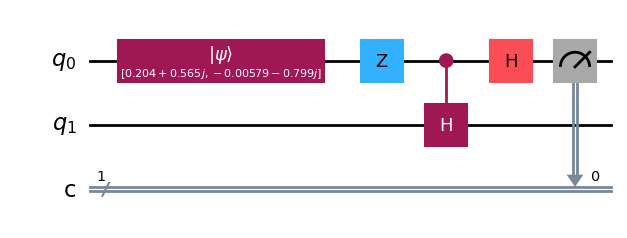

In [3]:
### Confirm that the Dilation Approach (eq 54) produces the correct state with success probability given by eq 56 

# initial state
a0 = np.random.rand() * 0.95
gamma = 2*pi * np.random.rand() # np.random.rand() + 1j*np.random.rand()
nshots = 2**15 # number of shots, reduces statistical noise

# run Dilation method
psuccess_aer, psuccess_theory, qc = method_dilation(a0,gamma,nshots)
print("FIG. 2. Quantum circuit implementation of non-unitary operator V in Eq.(49), following the procedure of Eq.(54). The measurement outcome in the first register is conditioned on the 0-bit value.")
print("prob (theory)", psuccess_aer)
print("prob (Aer)", psuccess_theory)
# Display circuit
qc.draw('mpl')

## LCU approach

For LCU, we decompose $\hat{V} = \sigma_z + (-\sigma_x) + \sigma_x\sigma_z$ in figure 3 of the paper.

FIG. 3. The LCU quantum circuit of Eq.(60), implementing the non-unitary operator V in Eq.(49).
prob (theory) 0.026519775390625
prob (Aer) 0.026208627492966832


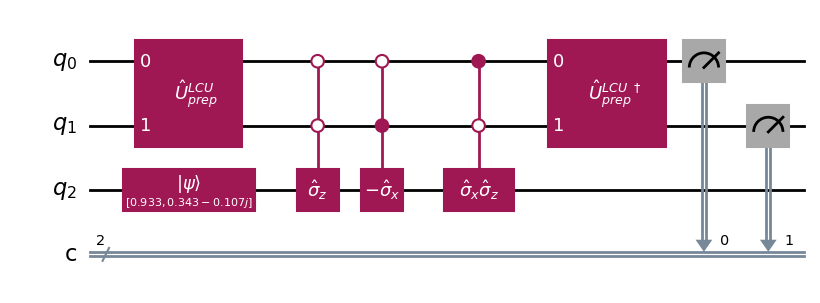

In [4]:
def method_lcu(a0,gamma,nshots):

    # define non-hermitian operation as in equation 49
    Vop = np.array([[1,-2],[0,-1]])
    
    # initial state    
    a1 = np.sqrt(1-a0**2) * exp(1j * gamma)
    psi0 = np.array([ a0, a1 ])
    #print("psi0", psi0 )
    
    # start quantum circuit
    qc = QuantumCircuit(3, 2)  # 2 ancillary qubits + 1 working qubit, 2 classical bits
    
    # Step 1: initialize psi0 at qubit 2
    qc.initialize(psi0, 2)

    ### build U_prep^LCU
    # The desired image of |00>:
    c0 = (1/np.sqrt(3))*np.array([1, 1, 1, 0], dtype=complex)
    # Three more orthonormal vectors, chosen so that {c0, c1, c2, c3} is a complete basis:
    # (You can pick many valid completions; this one is just a neat example.)
    c1 = (1/np.sqrt(6))*np.array([ 1,  1, -2,  0], dtype=complex)
    c2 = np.array([0, 0, 0, 1], dtype=complex)  # e_4
    c3 = (1/np.sqrt(2))*np.array([ 1, -1,  0,  0], dtype=complex)
    # Stack them as columns into a 4x4 unitary matrix:
    ULCU_prep = np.column_stack([c0, c1, c2, c3])
    # confirm unitarity
    """
    UdgU = np.conj(np.transpose(ULCU_prep)) @ ULCU_prep
    UdgU[np.abs(UdgU) < 1e-7] = 0
    UdgU
    """
    my_LCUgate = UnitaryGate(ULCU_prep, label="$\hat{U}_{prep}^{LCU}$")
    qc.append(my_LCUgate, [0, 1])

    
    # Define single-qubit matrices (as NumPy arrays)
    sz = np.array([[1, 0],
                   [0,-1]], dtype=complex)    
    sx = np.array([[0, 1],
                   [1, 0]], dtype=complex)
    minus_sx = -1 * sx         # gives the matrix for -sigma_x
    sxsz = sx @ sz             # matrix multiplication for sigma_x * sigma_z
    #
    U0 = UnitaryGate(sz,       label="$\hat{\sigma}_z$")
    U1 = UnitaryGate(minus_sx, label="$-\hat{\sigma}_x$")
    U2 = UnitaryGate(sxsz,     label="$\hat{\sigma}_x \hat{\sigma}_z$")

    # If ancillas == |00>, apply sigma_z
    qc.append(U0.control(2, ctrl_state=0), [0,1,2])
    qc.append(U1.control(2, ctrl_state=2), [0,1,2])
    qc.append(U2.control(2, ctrl_state=1), [0,1,2])

    my_LCUgate = UnitaryGate(np.conj(np.transpose(ULCU_prep)), label="$\hat{U}_{prep}^{LCU} {}^\dagger$")
    qc.append(my_LCUgate, [0, 1])

    
    # Measurement of ancillary qubit
    qc.measure(0, 0)
    qc.measure(1, 1)
    
    # Simulate the circuit
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=nshots).result()
    counts = result.get_counts()
    
    # Post-process results
    psuccess_aer = counts.get('00', 0) / nshots  # Probability of measuring '00'
    
    # expected probability for LCU
    psuccess_theory = ( np.abs(a0-2*a1)**2 + np.abs(a1)**2 )/9

    return psuccess_aer, psuccess_theory, qc

# initial state
a0 = np.random.rand() * 0.95
gamma = 2*pi * np.random.rand() # np.random.rand() + 1j*np.random.rand()
nshots = 2**15 # number of shots, reduces statistical noise

# run LCU method
psuccess_aer, psuccess_theory, qc = method_lcu(a0,gamma,nshots)
print("FIG. 3. The LCU quantum circuit of Eq.(60), implementing the non-unitary operator V in Eq.(49).")
print("prob (theory)", psuccess_aer)
print("prob (Aer)", psuccess_theory)
# Display circuit
qc.draw('mpl')

## Comparison of the two methods and theoretical success probabilities

Now we compare the two methods for different initial wavefunction against the theoretical predictions.

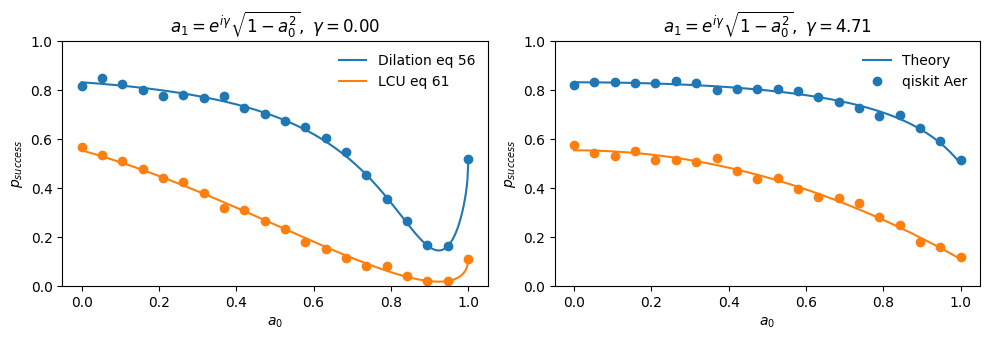

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5*2,3.5))

for i in range(2):
    a0 = np.linspace(0,1,500)
    gamma = pi * 1.5 * i
    
    a1 = np.sqrt(1-a0**2) * exp(1j * gamma)
    # Dilation eq 56: prob <= 5/6
    psuccess_dilation = ( np.abs(a0-2*a1)**2 + np.abs(a1)**2 )/( 2*( np.abs(a0-a1)**2 + 2*np.abs(a1)**2 ) ) 
    # LCU eq 61: prob <= 4/9
    psuccess_lcu = ( np.abs(a0-2*a1)**2 + np.abs(a1)**2 )/9


    # run method with sampling
    a0_lst = np.linspace(0,1,20)
    psuccess_dilation_aer = np.zeros_like(a0_lst)
    psuccess_lcu_aer = np.zeros_like(a0_lst)
    nshots = 2**10
    for j in range(len(a0_lst)):
        psuccess_dilation_aer[j], _, _ = method_dilation(a0_lst[j],gamma,nshots)
        psuccess_lcu_aer[j], _, _ = method_lcu(a0_lst[j],gamma,nshots)
    
    if i==0:
        # plot theory
        axes[i].plot( a0, psuccess_dilation, color='tab:blue', label=r'Dilation eq 56' )
        axes[i].plot( a0, psuccess_lcu, color='tab:orange', label=r'LCU eq 61' )
        # plot aer
        axes[i].plot(a0_lst, psuccess_dilation_aer, 'o', color='tab:blue')
        axes[i].plot(a0_lst, psuccess_lcu_aer, 'o', color='tab:orange')
    elif i==1:
        # plot theory
        axes[i].plot( a0, psuccess_dilation, color='tab:blue', label=r'Theory' )
        axes[i].plot( a0, psuccess_lcu, color='tab:orange' )
        # plot aer
        axes[i].plot(a0_lst, psuccess_dilation_aer, 'o', color='tab:blue', label=r'qiskit Aer')
        axes[i].plot(a0_lst, psuccess_lcu_aer, 'o', color='tab:orange')
    
    axes[i].set_ylim([0,1])
    axes[i].set_xlabel(r'$a_0$')
    axes[i].set_ylabel(r'$p_{success}$')
    axes[i].set_title(r'$a_1=e^{i \gamma} \sqrt{1-a_0^2},'+'~\gamma={:.2f}$'.format(gamma) )
    axes[i].legend(frameon=False)
plt.tight_layout()
plt.show()